In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans


In [3]:
waverly_df_original = pd.read_csv('/content/holdings_clean.csv')
waverly_df_original.head()

,clientID,Reg ID,Reg Type,Account ID,Value,Position Weight,Product Name,Ticker,Cusip,Asset Category,...,Product Subtype,Mgmt Style,As Of Date,Cost Basis,Unrealized Gain/Loss,Is Active,Custodian,Rep ID,Purchase Date,Included in Billing and Fees
0,36,1299,Individual,273,25241.25,0.43,California St Public Wks Brd Lease Rev Bds Cal...,13068LMB8,13068LMB8,Fixed Income,...,Municipal Bond,Moderately-Conservative,3/1/24,28756.00,-3514.75,True,Fidelity,479,4/7/14 0:00,Y
1,36,1299,Individual,273,24902.75,0.42,Loudoun Cnty VA 3.00% 12/1/2024,54589TBG6,54589TBG6,Fixed Income,...,Municipal Bond,Moderately-Conservative,3/1/24,26833.50,-1930.75,True,Fidelity,479,3/17/21 0:00,Y
2,36,1299,Individual,273,25222.25,0.43,Allegany Cnty NY Serial Bds Ser 2014 5.00% 9/1...,017086FE4,017086FE4,Fixed Income,...,Municipal Bond,Moderately-Conservative,3/1/24,30681.75,-5459.50,True,Fidelity,479,2/5/15 0:00,Y
3,36,1299,Individual,273,25872.50,0.44,Laredo TX 4.00% 2/15/2032,516824GZ6,516824GZ6,Fixed Income,...,Municipal Bond,Moderately-Conservative,3/1/24,26692.75,-820.25,True,Fidelity,479,12/27/18 0:00,Y
4,36,1299,Individual,273,25405.75,0.43,Jefferson Cnty KY Sch Dist Fin Corp 4.00% 12/1...,4729044S7,4729044S7,Fixed Income,...,Municipal Bond,Moderately-Conservative,3/1/24,27259.75,-1854.00,True,Fidelity,479,5/20/15 0:00,Y


In [ ]:
# Create a table with ROW = {ClientID} COL={TotalValue, HoldingCount, AvgReturn, MedReturn, CashPct, ACWI/AGG ratio}
waverly_df = pd.read_csv('/content/holdings_clean.csv')
waverly_df_summary = waverly_df.groupby('clientID').agg({'Ticker':'nunique', 'Value': 'sum','Unrealized Gain/Loss':'mean','Unrealized Gain/Loss':'median'}).rename(columns={'Value':'Total Value','Ticker':'Holding Count', 'Unrealized Gain/Loss':'Average Return','Unrealized Gain/Loss':'Median Return'})
waverly_df_summary['Average Return'] = waverly_df.groupby('clientID').agg({'Unrealized Gain/Loss':'mean'})
dfCsh = waverly_df[waverly_df['Asset Category'] == 'Cash and Equivalents'].copy()
waverly_df_summary['Cash Total'] = dfCsh.groupby('clientID').agg({'Value':'sum'}).rename(columns={'Value':'Total Cash'})
waverly_df_summary['Cash Total'] = waverly_df_summary['Cash Total'].fillna(0)
waverly_df_summary['CashPct'] = (waverly_df_summary['Cash Total']/waverly_df_summary['Total Value'])*100
waverly_df_summary = waverly_df_summary.drop(columns=['Cash Total'])
waverly_df_summary.to_csv('waverly_data.csv')
waverly_df_summary= waverly_df_summary.dropna()
waverly_df_summary.head()

In [ ]:
# Identify possible values to use for ACWI vs AGG
l1 = list(waverly_df['Product Type'])
l1 = list(set(l1))
print('possble investment product types: ' + str(l1))

possble investment product types: ['Miscellaneous', 'Annuity', 'Option', 'Bond', 'CD', 'Stock/ETF', 'Mutual Fund']


In [6]:
# Calculate ACWI/AGG ratio
waverly_df['is_stock_etf'] = waverly_df['Product Type'].apply(lambda x: 1 if x == 'Stock/ETF'  else 0)
waverly_df['is_bond'] = waverly_df['Product Type'].apply(lambda x: 1 if x == 'Bond' or x == 'CD' or x == 'Annuity' else 0)
high_risk_value = waverly_df.groupby('clientID').apply(lambda x: x[x['is_stock_etf'] == 1]['Value'].sum() if x['is_stock_etf'].sum() > 0 else 1).rename('high_risk_value')
low_risk_value = waverly_df.groupby('clientID').apply(lambda x: x[x['is_bond'] == 1]['Value'].sum() if x['is_bond'].sum() > 0 else 1).rename('low_risk_value')
acwi_agg_ratio = high_risk_value / low_risk_value

# Add ACWI/AGG ratio to filtered csv
waverly_df_new = pd.read_csv('/content/holdings_summary.csv')
acwi_agg_ratio_dict = acwi_agg_ratio.to_dict()
waverly_df_new['ACWI/AGG'] = waverly_df_new['clientID'].map(acwi_agg_ratio_dict)
waverly_df_new.to_csv('/content/holdings_summary.csv', index=False)

waverly_df_new.head()

,clientID,Holding Count,Total Value,Median Return,Average Return,CashPct,ACWI/AGG
0,36,233,14679336.01,-499.575,14784.754973,-0.187241,0.889552
1,38,24,1322623.14,3203.990,4379.942500,0.000000,357333.550000
2,39,12,822126.35,2390.890,23827.818182,0.000000,811431.620000
3,41,19,1565740.86,4440.600,6859.645556,0.000000,452207.560000
4,42,4,81438.29,-94.600,16035.173333,0.000000,73329.050000


<ipython-input-7-09966e5eac7c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='clientID', y='Average Return', data=sorted_data, palette='viridis')


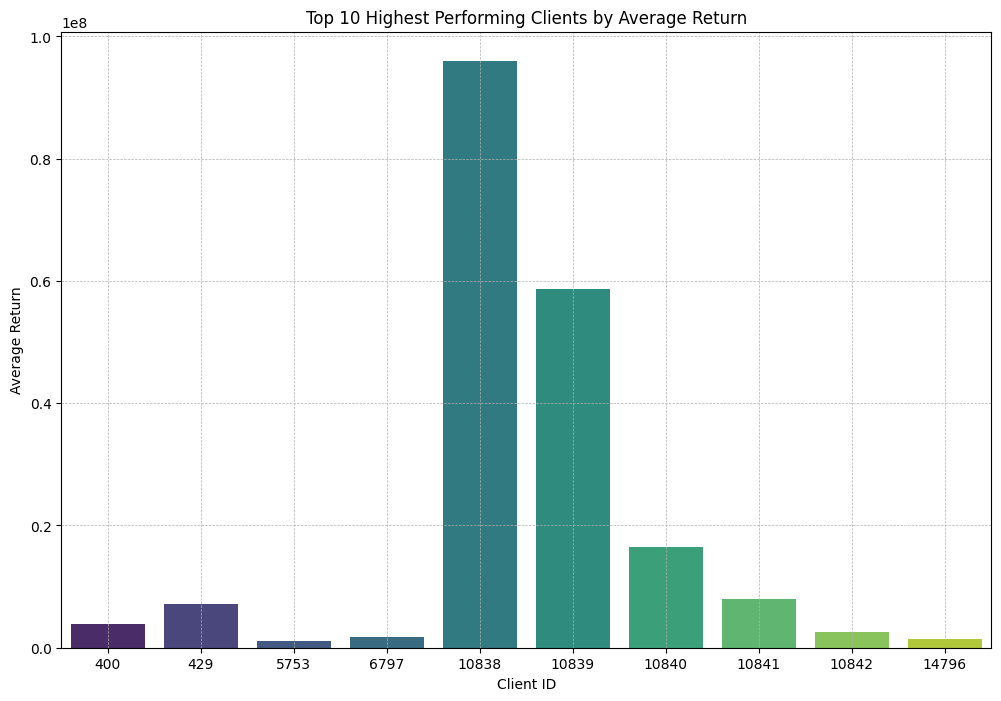


Client to Rep Mapping:
10838: 517
10839: 517
10840: 517
10841: 517
429: 475
400: 474
10842: 517
6797: 504
14796: 536
5753: 476


,clientID,Holding Count,Total Value,Median Return,Average Return,CashPct,ACWI/AGG
2239,10838,1,9.596845e+07,9.596845e+07,9.596845e+07,0.000000,1.00
2240,10839,1,5.945053e+07,5.875053e+07,5.875053e+07,0.000000,1.00
2241,10840,1,1.640157e+07,1.640157e+07,1.640157e+07,0.000000,1.00
2242,10841,1,7.951940e+06,7.951940e+06,7.951940e+06,0.000000,1.00
146,429,21,1.839780e+08,1.529831e+06,7.159222e+06,2.130613,1.00
134,400,18,2.079494e+08,-3.586000e+01,3.930617e+06,0.320792,8170620.42
2243,10842,1,9.867344e+06,2.552034e+06,2.552034e+06,0.000000,1.00
749,6797,9,2.074144e+07,7.942716e+05,1.696004e+06,0.168301,9173333.80
4049,14796,4,4.242690e+06,1.819390e+03,1.413195e+06,0.000365,4242674.55
459,5753,17,4.210902e+07,1.979470e+05,1.077268e+06,0.000000,41958615.68


In [7]:
top_n = 10

sorted_data = waverly_df_new.sort_values(by='Average Return', ascending=False).head(top_n)
plt.figure(figsize=(12, 8))
sns.barplot(x='clientID', y='Average Return', data=sorted_data, palette='viridis')
plt.title(f'Top {top_n} Highest Performing Clients by Average Return')
plt.xlabel('Client ID')
plt.ylabel('Average Return')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

sorted_data[['clientID', 'Holding Count', 'Total Value', 'Median Return', 'Average Return', 'CashPct', 'ACWI/AGG']]
client_rep_mapping = {}

for client_id in sorted_data['clientID'].unique():
    if client_id in waverly_df['clientID'].values:
        rep_id = waverly_df.loc[waverly_df['clientID'] == client_id, 'Rep ID'].iloc[0]

        client_rep_mapping[client_id] = rep_id
    else:
        print(f"Warning: clientID {client_id} not found in waverly_df")

print("\nClient to Rep Mapping:")

for i in sorted_data['clientID']:
    print(str(i) + ': ' + str(client_rep_mapping[i]))
sorted_data[['clientID', 'Holding Count', 'Total Value', 'Median Return', 'Average Return', 'CashPct', 'ACWI/AGG']]

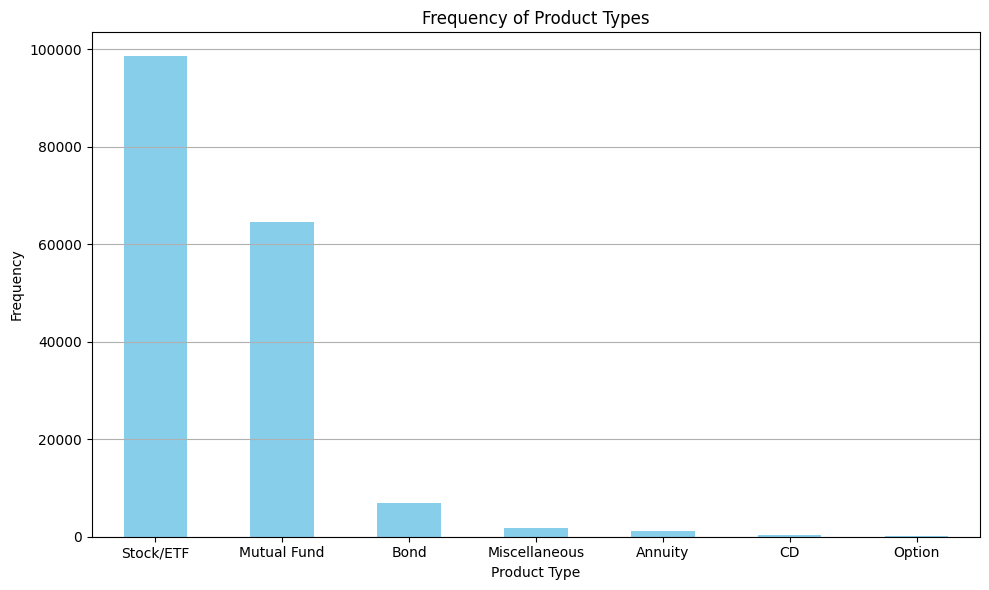

In [8]:
frequency = waverly_df['Product Type'].value_counts()

plt.figure(figsize=(10, 6))
frequency.plot(kind='bar', color='skyblue')
plt.title('Frequency of Product Types')
plt.xlabel('Product Type')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

Analyzing Top 10 Clients

In [10]:
import pandas as pd
waverly = pd.read_csv('/content/holdings_clean.csv')
client_ids = [10838, 10839, 10840, 10841, 429, 400, 10842, 6797, 14796, 5753]
waverly_top_10 = waverly[waverly['clientID'].isin(client_ids)]
unique_reg_types = waverly_top_10.groupby('clientID')['Reg Type'].unique()
unique_representatives = waverly_top_10.groupby('clientID')['Rep ID'].unique()
merged_dataset = pd.merge(unique_reg_types, unique_representatives, on='clientID', how='inner')
print(merged_dataset)


                                Reg Type Rep ID
clientID                                       
400                         [Non-Profit]  [474]
429                [Profit Sharing Plan]  [475]
5753      [Individual, IRA Contributory]  [476]
6797                       [Partnership]  [504]
10838       [Non-Traditional Investment]  [517]
10839       [Non-Traditional Investment]  [517]
10840       [Non-Traditional Investment]  [517]
10841       [Non-Traditional Investment]  [517]
10842       [Non-Traditional Investment]  [517]
14796      [Beneficiary IRA, Individual]  [536]


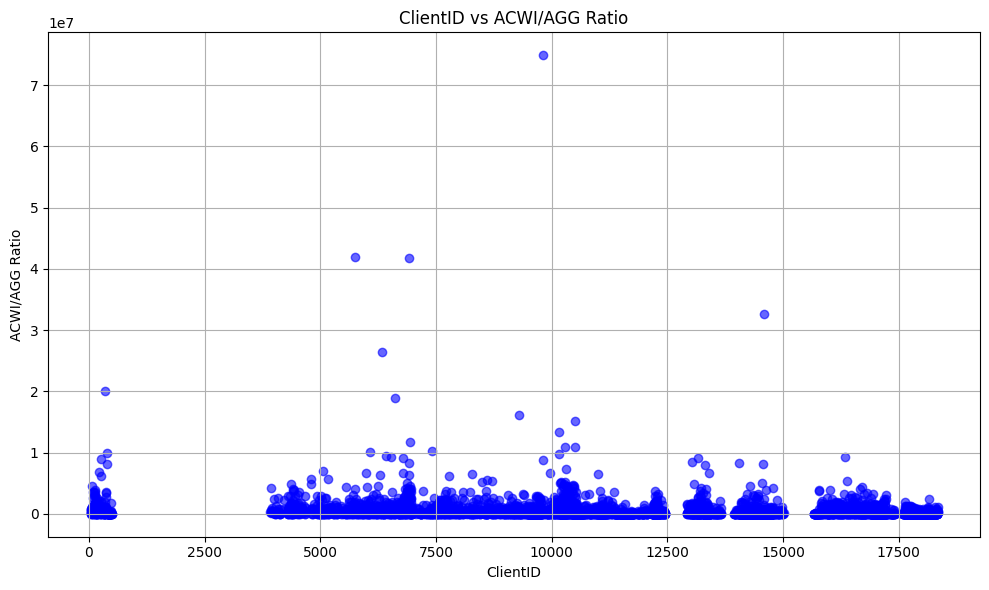

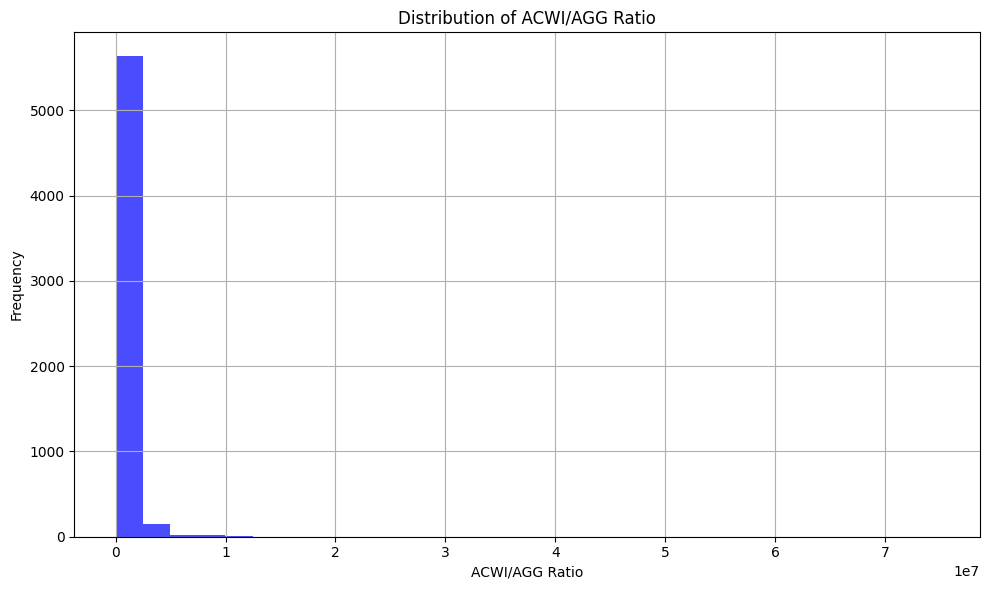

3
850


In [11]:
# Searching for outliers on ACWI/AGG Ratio
plt.figure(figsize=(10, 6))
plt.scatter(waverly_df_new['clientID'], waverly_df_new['ACWI/AGG'], alpha=0.6, color='blue')
plt.title('ClientID vs ACWI/AGG Ratio')
plt.xlabel('ClientID')
plt.ylabel('ACWI/AGG Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

filtered_acwi_agg = waverly_df_new['ACWI/AGG'][np.isfinite(waverly_df_new['ACWI/AGG'])]
plt.figure(figsize=(10, 6))
plt.hist(filtered_acwi_agg, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of ACWI/AGG Ratio')
plt.xlabel('ACWI/AGG Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# how many times is it 0?
num_times_zero = (waverly_df_new['ACWI/AGG'] == 0).sum()
print(num_times_zero)
# how many times is it 1?
num_times_zero = (waverly_df_new['ACWI/AGG'] == 1).sum()
print(num_times_zero)

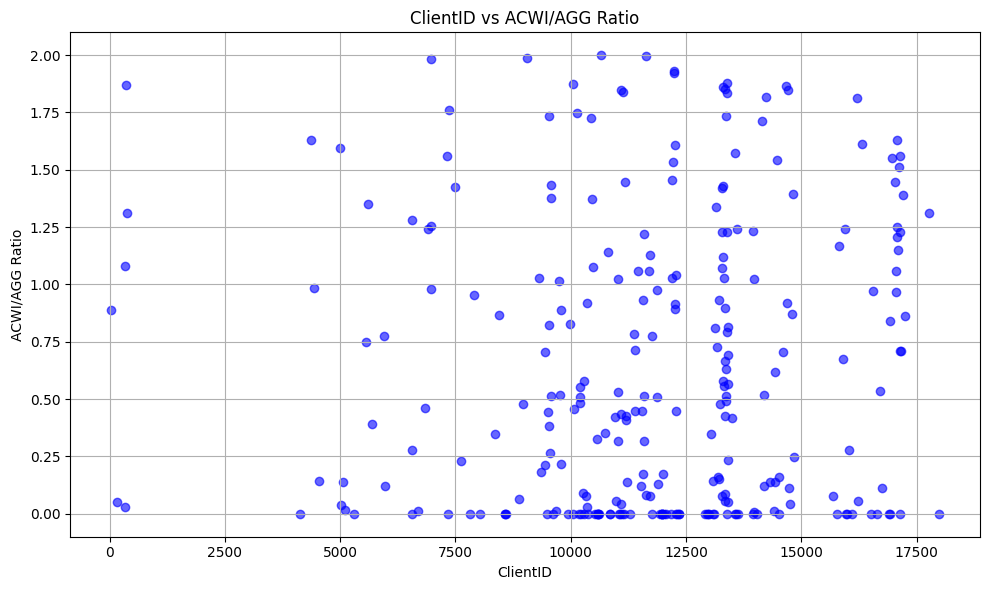

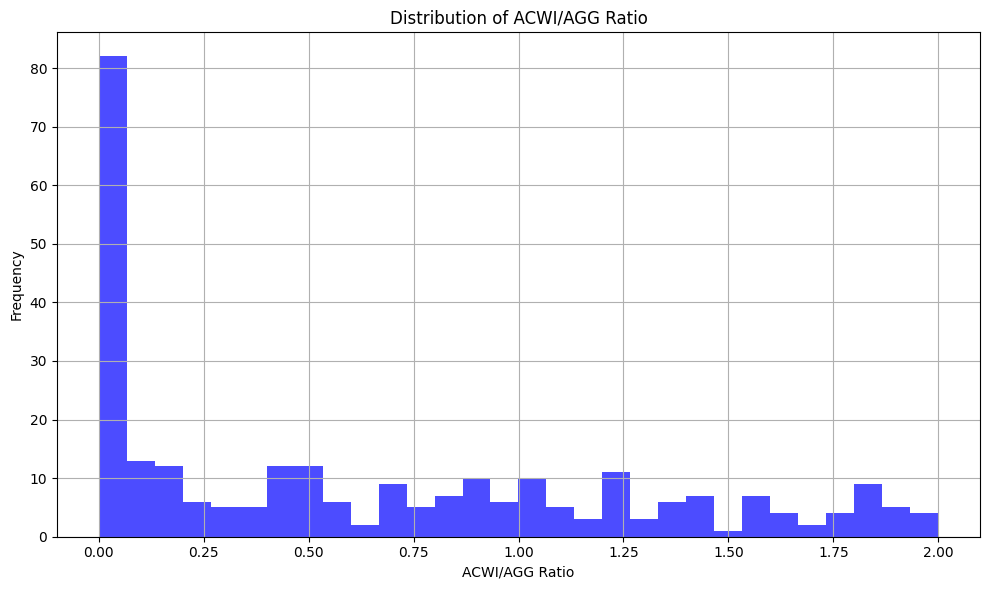

0
0


In [12]:
# taking out the outliers for trend purposes

waverly_df_clean = waverly_df_new[
    (waverly_df_new['ACWI/AGG'] < 2) &
    (waverly_df_new['ACWI/AGG'] != 1) &
    (waverly_df_new['ACWI/AGG'] != 0)
]

# running the plots again

plt.figure(figsize=(10, 6))
plt.scatter(waverly_df_clean['clientID'], waverly_df_clean['ACWI/AGG'], alpha=0.6, color='blue')
plt.title('ClientID vs ACWI/AGG Ratio')
plt.xlabel('ClientID')
plt.ylabel('ACWI/AGG Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

filtered_acwi_agg = waverly_df_clean['ACWI/AGG'][np.isfinite(waverly_df_clean['ACWI/AGG'])]
plt.figure(figsize=(10, 6))
plt.hist(filtered_acwi_agg, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of ACWI/AGG Ratio')
plt.xlabel('ACWI/AGG Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# how many times is it 0?
num_times_zero = (waverly_df_clean['ACWI/AGG'] == 0).sum()
print(num_times_zero)
# how many times is it 1?
num_times_zero = (waverly_df_clean['ACWI/AGG'] == 1).sum()
print(num_times_zero)

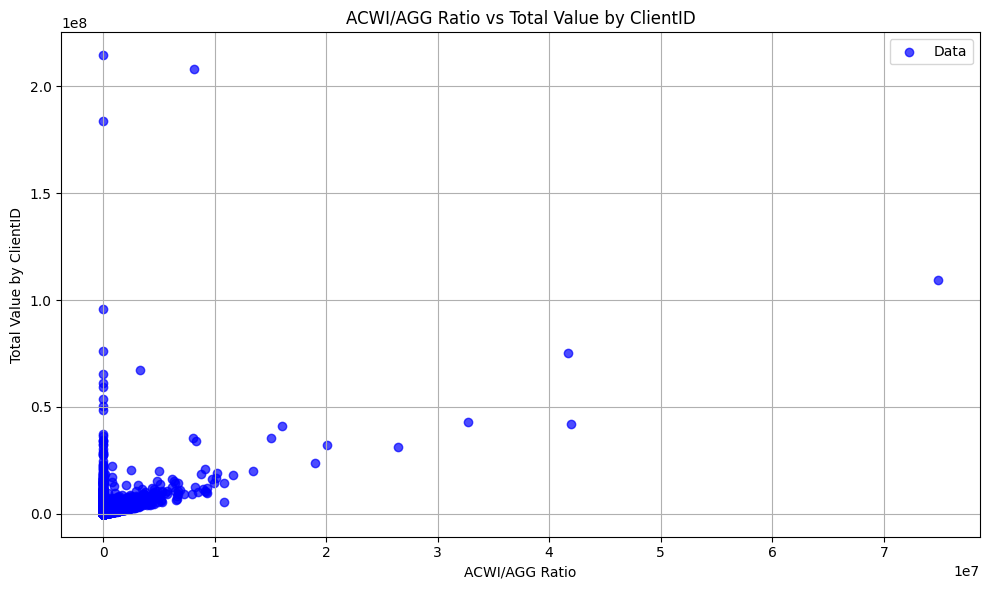

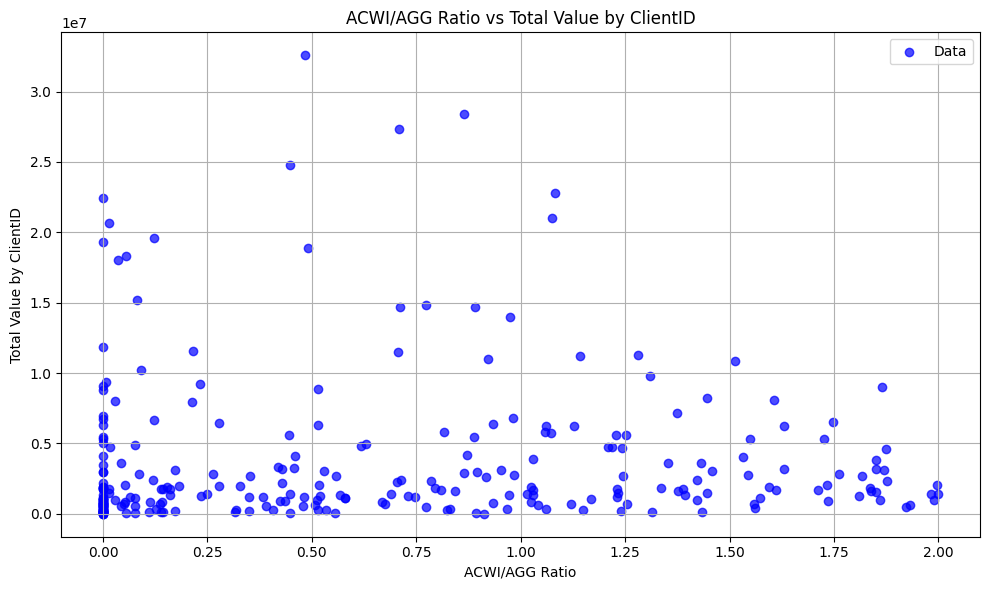

In [13]:
# plot with all data

total_value_by_client = waverly_df_new.groupby('clientID')['Total Value'].sum().reset_index()

merged_df = pd.merge(total_value_by_client, waverly_df_new[['clientID', 'ACWI/AGG']].drop_duplicates(), on='clientID', how='inner')

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['ACWI/AGG'], merged_df['Total Value'], alpha=0.7, color='blue', label='Data')
plt.title('ACWI/AGG Ratio vs Total Value by ClientID')
plt.xlabel('ACWI/AGG Ratio')
plt.ylabel('Total Value by ClientID')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# plot without outliers

total_value_by_client = waverly_df_clean.groupby('clientID')['Total Value'].sum().reset_index()

merged_df = pd.merge(total_value_by_client, waverly_df_clean[['clientID', 'ACWI/AGG']].drop_duplicates(), on='clientID', how='inner')

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['ACWI/AGG'], merged_df['Total Value'], alpha=0.7, color='blue', label='Data')
plt.title('ACWI/AGG Ratio vs Total Value by ClientID')
plt.xlabel('ACWI/AGG Ratio')
plt.ylabel('Total Value by ClientID')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [186]:
dfWys = waverly_df_new
dfWys= dfWys.dropna()

# Select 'clientID', 'Total Value', and 'Median Return' columns from dfWys
X = dfWys[['clientID', 'Total Value', 'Median Return']]

# Set 'clientID' as the index of the DataFrame
X.set_index('clientID', inplace=True)

X.head()

#X = dfWys[['Total Value', 'Median Return']]
#X

,Total Value,Median Return
clientID,,
36,14679336.01,-499.575
38,1322623.14,3203.990
39,822126.35,2390.890
41,1565740.86,4440.600
42,81438.29,-94.600


In [187]:
columns_to_scale = ['Total Value', 'Median Return']
X[X.columns] = scale(X[columns_to_scale])
#Define
mdlDbsWvy = DBSCAN(eps=3, min_samples=2)
#Fit
mdlDbsWvy.fit(X)
dbscan_labels = mdlDbsWvy.labels_
#Evaluate
silhouette_score(X, dbscan_labels)

<ipython-input-187-f80d47cd4d4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[X.columns] = scale(X[columns_to_scale])


0.984927535823047

In [188]:
# count clusters

dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_clusters

2

In [189]:
# count anomalies

dbscan_anomalies = list(dbscan_labels).count(-1)
dbscan_anomalies

6

Text(0, 0.5, 'Total Value')

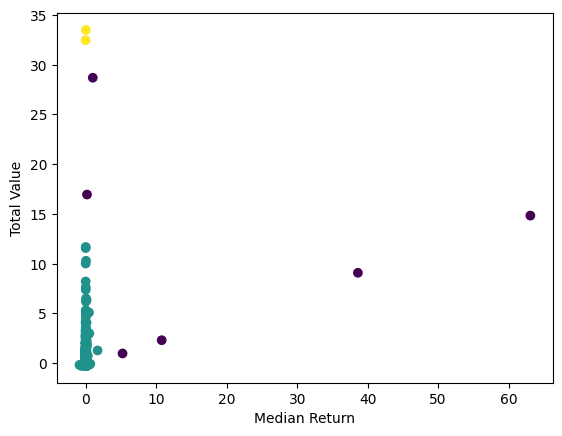

In [190]:
plt.scatter(X['Median Return'],X['Total Value'], c = dbscan_labels)
plt.xlabel('Median Return')
plt.ylabel('Total Value')

In [191]:
X['Cluster'] = dbscan_labels

X_1 = X[X['Cluster'] == 0].drop('Cluster', axis=1)

anamolies = X[X['Cluster'] != 0].drop('Cluster', axis=1)
anamolies

<ipython-input-191-ac7bfcf49b64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cluster'] = dbscan_labels


,Total Value,Median Return
clientID,,
400,32.473161,-0.024919
429,28.697121,0.981387
6377,33.505695,0.009554
9813,16.951562,0.160156
10838,14.833569,63.100616
10839,9.081149,38.619653
10840,2.299938,10.763625
10841,0.968925,5.205681


In [192]:
X_1[X_1.columns] = scale(X_1[X_1.columns])

mdlDbsWvy.fit(X_1)


dbscan_labels = mdlDbsWvy.labels_

#Evaluate
silhouette_score(X_1, dbscan_labels)

0.9585936536525429

In [193]:
# count clusters

dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_clusters

2

In [194]:
# count anomalies

dbscan_anomalies = list(dbscan_labels).count(-1)
dbscan_anomalies

8

Text(0, 0.5, 'Total Value')

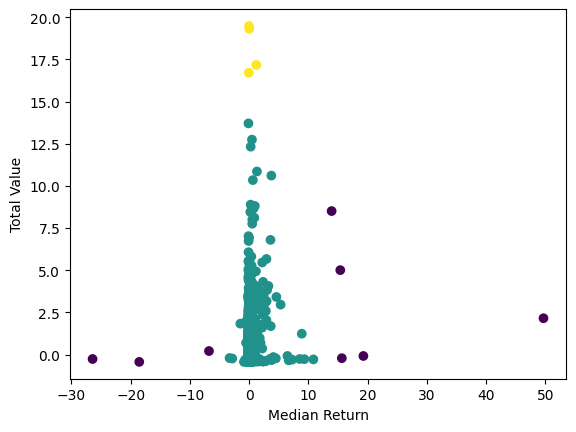

In [195]:
plt.scatter(X_1['Median Return'],X_1['Total Value'], c = dbscan_labels)
plt.xlabel('Median Return')
plt.ylabel('Total Value')

In [196]:
X_1['Cluster'] = dbscan_labels

X_2 = X_1[X_1['Cluster'] == 0].drop('Cluster', axis=1)

anamolies_1 = X_1[X_1['Cluster'] != 0].drop('Cluster', axis=1)

anamolies = pd.concat([anamolies, anamolies_1])
anamolies

,Total Value,Median Return
clientID,,
400,32.473161,-0.024919
429,28.697121,0.981387
6377,33.505695,0.009554
9813,16.951562,0.160156
10838,14.833569,63.100616
10839,9.081149,38.619653
10840,2.299938,10.763625
10841,0.968925,5.205681
6375,19.488464,-0.031129


In [197]:
#Define
mdlKmcWvy = KMeans(n_clusters=4, random_state=1)

#Fit
mdlKmcWvy.fit(X_2)


kmeans_labels = mdlKmcWvy.labels_

#Evaluate
silhouette_score(X_2, kmeans_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.7760802366431975

Text(0, 0.5, 'Total Value')

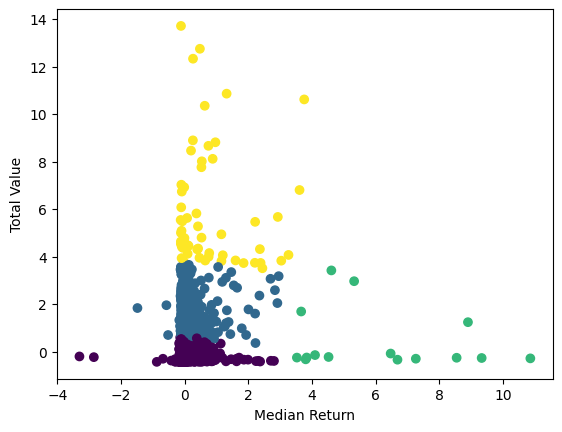

In [198]:
plt.scatter(X_2['Median Return'],X_2['Total Value'], c = kmeans_labels)
plt.xlabel('Median Return')
plt.ylabel('Total Value')


In [199]:
X_2['Cluster'] = kmeans_labels
X_2

,Total Value,Median Return,Cluster
clientID,,,
36,3.419433,-0.120956,1
38,-0.084327,-0.048653,0
39,-0.215619,-0.064526,0
41,-0.020552,-0.024511,0
42,-0.409918,-0.113050,0
...,...,...,...
18340,-0.395105,-0.109215,0
18341,-0.077998,-0.030698,0
18342,-0.290820,-0.108874,0


In [200]:
LowValue_HighReturn = X_2[X_2['Cluster'] == 2].drop('Cluster', axis=1)
LowValue_HighReturn

,Total Value,Median Return
clientID,,
129,1.239606,8.893561
462,3.417964,4.605373
8572,-0.339424,6.681009
10263,-0.297967,7.257230
10319,1.689005,3.657650
10538,-0.144853,4.092590
10599,-0.224802,4.517983
10618,-0.283908,10.852434
10633,-0.251281,3.523484


In [201]:
LowReturn_HighValue = X_2[X_2['Cluster'] == 3].drop('Cluster', axis=1)
LowReturn_HighValue

,Total Value,Median Return
clientID,,
99,4.314033,2.361867
190,4.475242,0.102055
257,13.708280,-0.115436
263,3.787269,-0.024775
330,5.541628,-0.125126
339,8.010506,0.538000
415,3.509680,2.440409
428,6.801860,3.606539
441,4.069501,3.259803


In [202]:
import pandas as pd

combined_df = pd.concat([LowValue_HighReturn, LowReturn_HighValue])
combined_df.index.name = 'clientID'

filtered_df = waverly_df_original[waverly_df_original['clientID'].isin(combined_df.index)]

def map_cluster(client_id):
    if client_id in LowValue_HighReturn.index:
        return 'LowValue_HighReturn'
    elif client_id in LowReturn_HighValue.index:
        return 'LowReturn_HighValue'
    else:
        return None

filtered_df['Cluster'] = filtered_df['clientID'].apply(map_cluster)

filtered_df.to_csv('filtered_dataframe_with_cluster.csv', index=False)

filtered_df.head(50)

<ipython-input-202-e2a952b7366c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Cluster'] = filtered_df['clientID'].apply(map_cluster)


,clientID,Reg ID,Reg Type,Account ID,Value,Position Weight,Product Name,Ticker,Cusip,Asset Category,...,Mgmt Style,As Of Date,Cost Basis,Unrealized Gain/Loss,Is Active,Custodian,Rep ID,Purchase Date,Included in Billing and Fees,Cluster
1162,99,24547,401(K),24186,9674.20,0.05,DFA Inflation-Protected Secs,DIPSX,233203355,Fixed Income,...,Managed - Discretionary,3/1/24,1.411046e+03,8.263154e+03,True,Mid Atlantic Capital Group,475,11/16/21 0:00,Y,LowReturn_HighValue
1163,99,24547,401(K),24186,699057.90,3.86,Vanguard Divid Appreciation Index Admiral,VDADX,921908828,Equities,...,Managed - Discretionary,3/1/24,6.495832e+05,4.947469e+04,True,Mid Atlantic Capital Group,475,7/27/23 0:00,Y,LowReturn_HighValue
1164,99,24547,401(K),24186,550641.12,3.04,Avantis US Small Cap Value Fund,AVUVX,25072828,Equities,...,Managed - Discretionary,3/1/24,4.745456e+05,7.609553e+04,True,Mid Atlantic Capital Group,475,6/13/22 0:00,Y,LowReturn_HighValue
1165,99,24547,401(K),24186,90.93,0.00,Fidelity 500 Index Fund,FXAIX,315911750,Equities,...,Managed - Discretionary,3/1/24,8.873990e+01,2.190100e+00,True,Mid Atlantic Capital Group,475,1/12/24 0:00,Y,LowReturn_HighValue
1166,99,24547,401(K),24186,637400.44,3.52,Vanguard Mid Cap Value Index Adm,VMVAX,921937694,Equities,...,Managed - Discretionary,3/1/24,2.694137e+05,3.679867e+05,True,Mid Atlantic Capital Group,475,11/16/21 0:00,Y,LowReturn_HighValue
1167,99,24547,401(K),24186,978646.30,5.41,Vanguard Inter-Term Inv Grade Adm,VFIDX,922031810,Fixed Income,...,Managed - Discretionary,3/1/24,5.376497e+05,4.409966e+05,True,Mid Atlantic Capital Group,475,11/16/21 0:00,Y,LowReturn_HighValue
1168,99,24547,401(K),24186,1122158.49,6.20,Mellon Stable Value M,58552T205,58552T205,Cash and Equivalents,...,Managed - Discretionary,3/1/24,NaN,NaN,True,Mid Atlantic Capital Group,475,11/16/21 0:00,Y,LowReturn_HighValue
1169,99,24547,401(K),24186,388798.86,2.15,Vanguard Small Cap Growth Index Adm,VSGAX,921937710,Equities,...,Managed - Discretionary,3/1/24,2.192074e+05,1.695914e+05,True,Mid Atlantic Capital Group,475,11/16/21 0:00,Y,LowReturn_HighValue
1170,99,24547,401(K),24186,430305.69,2.38,Vanguard Mid Cap Growth Index Admiral,VMGMX,921937728,Equities,...,Managed - Discretionary,3/1/24,2.292590e+05,2.010467e+05,True,Mid Atlantic Capital Group,475,11/16/21 0:00,Y,LowReturn_HighValue
1171,99,24547,401(K),24186,3383279.83,18.70,Vanguard Growth Index Admiral,VIGAX,922908660,Equities,...,Managed - Discretionary,3/1/24,1.407742e+06,1.975538e+06,True,Mid Atlantic Capital Group,475,11/16/21 0:00,Y,LowReturn_HighValue
